# **NFL: Running Backs Stats**
<img src="images/leveon_bell.jpeg" width='300px'>

In [1]:
import pandas as pd 
import numpy as np 
import boto3 
import json 
import time 
import os 
from bs4 import BeautifulSoup 
import urllib 

import seaborn as sns 
import matplotlib.pyplot as plt 

from typing import List, Dict 

plt.style.use('ggplot')

# **Helper Functions** 

In [33]:
def search_player(search_player_url: str, player_name: str) -> List[Dict]: 
    """
    NAME 
        search_player 

    DESCRIPTION
        Helper function to search current NFL Player stats 

    PARAMETER 
        - search_player_url: a valid NFL url 
        - player_name: a valid NFL player 

    RETURNS 
        A list of dictionary containing a player stat attributes 

    EXAMPLES 
        >>> search_player(search_player_url=search_player_url, player_name='James Harrison')
        >>> [{'player_name': 'Nick Chubb',
              'player_id': 'nick_chubb',
              'data': '{"data_1": [{"Unnamed: 0_level_0 Year": "2018", "Unnamed: ...
              ... snip ]
    """
    encoded_name: str = ''.join(map(lambda char: char if char.isalnum()  else hex(ord(char)).replace("0x", "%").strip(), player_name)).lower()

    resp: bytes = urllib.request.urlopen(url=search_player_url % (encoded_name) )
    soup: BeautifulSoup = BeautifulSoup(resp)
    results: List = []

    try:
        curr_data: Dict = {}
        for index,item in enumerate(pd.io.html.read_html(search_player_url % (encoded_name) ), 1): # try original url 
            curr_df: 'DataFrame' = item 
            curr_df.columns = [ ' '.join(col) if isinstance(col, tuple) else col for col in curr_df.columns ]
            curr_data[f"data_{index}"] = curr_df.to_dict(orient='records')

        # visit page, collect, and encode current player stats 
        results.append({'player_name': player_name,
                        'player_id': player_name.replace(' ', '_').lower() ,
                        'data': json.dumps(curr_data)
                       })

        return results 
        
    except: 
        pass 
        
    for tag in soup.find_all('div'): # revisit 
        if tag.has_attr('id') and tag.get('id') == 'players':
            for link in tag.find_all('a'): 
                if 'htm' in link.get('href'): 
                    url: str =  "%s%s" % ('/'.join(search_player_url.split("/")[:3]), link.get('href' ) ) 
    
                    curr_data: Dict = {}
                    for index,item in enumerate(pd.io.html.read_html(url), 1):
                        curr_df: 'DataFrame' = item 
                        curr_df.columns = [ ' '.join(col) if isinstance(col, tuple) else col for col in curr_df.columns ]
                        curr_data[f"data_{index}"] = curr_df.to_dict(orient='records')
    
                    # visit page, collect, and encode current player stats 
                    results.append({'player_name': player_name,
                                    'url': os.path.basename(url).replace(".htm", "").strip(),
                                    'data': json.dumps(curr_data)
                                   })

    return results
                

## **AWS Helpers** 

In [2]:
years: range = range(1973,2024)
secrets: 'SecretsManager' = boto3.client('secretsmanager')
rushing_stats: str = json.loads(secrets.get_secret_value(SecretId='nfl_stats') .get('SecretString') ).get('rushing_stats')
dst_path: str = json.loads(secrets.get_secret_value(SecretId='nfl_stats') .get('SecretString') ).get('dataset_path')
dbg_msg: str = "[ \033[92m+\033[0m ]"

## **Rushing Stats Leaders**

In [3]:
search_results: List = []
for year in years: 
    curr_df: 'DataFrame' = pd.io.html.read_html(rushing_stats % (year))[0] 
    curr_df['Year'] = [year] * curr_df.shape[0] 
    search_results.extend(curr_df.to_dict(orient='records'))
    print("%s Collecting Rushing Stats for %s" % (dbg_msg, year) )
    time.sleep(np.random.choice(range(1,3)) )

[ + ] Collecting Rushing Stats for 1973
[ + ] Collecting Rushing Stats for 1974
[ + ] Collecting Rushing Stats for 1975
[ + ] Collecting Rushing Stats for 1976
[ + ] Collecting Rushing Stats for 1977
[ + ] Collecting Rushing Stats for 1978
[ + ] Collecting Rushing Stats for 1979
[ + ] Collecting Rushing Stats for 1980
[ + ] Collecting Rushing Stats for 1981
[ + ] Collecting Rushing Stats for 1982
[ + ] Collecting Rushing Stats for 1983
[ + ] Collecting Rushing Stats for 1984
[ + ] Collecting Rushing Stats for 1985
[ + ] Collecting Rushing Stats for 1986
[ + ] Collecting Rushing Stats for 1987
[ + ] Collecting Rushing Stats for 1988
[ + ] Collecting Rushing Stats for 1989
[ + ] Collecting Rushing Stats for 1990
[ + ] Collecting Rushing Stats for 1991
[ + ] Collecting Rushing Stats for 1992
[ + ] Collecting Rushing Stats for 1993
[ + ] Collecting Rushing Stats for 1994
[ + ] Collecting Rushing Stats for 1995
[ + ] Collecting Rushing Stats for 1996
[ + ] Collecting Rushing Stats for 1997


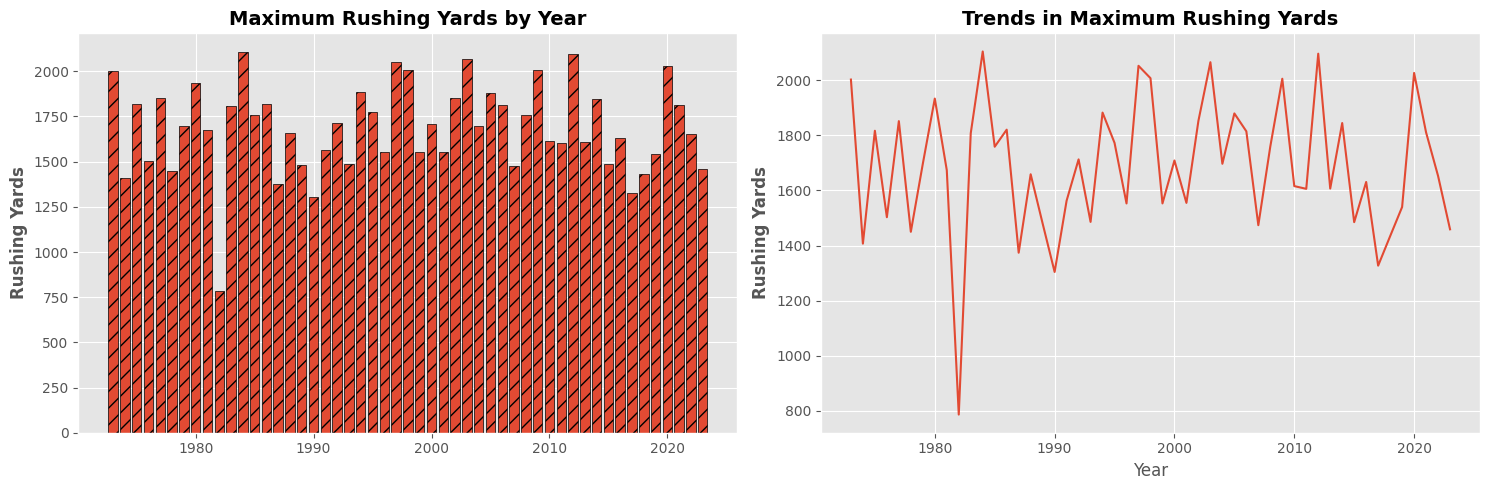

In [7]:
rushing_stats_df: 'DataFrame' = pd.DataFrame( search_results ) # player_team @year, against @opp
rushing_stats_df.to_csv(os.path.join(dst_path, 'rushing_stats_leaders.csv' ) )
years, yds = zip(*rushing_stats_df.groupby(['Year'])['Rush Yds'].max().to_dict().items())


stats: List = []
for year in rushing_stats_df['Year'].unique().tolist(): 
    stats.extend(rushing_stats_df.query(f"Year == {year}").sort_values(by='Rush Yds', ascending=False)[['Player', 'Rush Yds', 'Att', 'Year', 'Rush FUM']].head(1).to_dict(orient='records'))
stats_df: 'DataFrame' = pd.DataFrame(stats) 
stats_df['encoded_name'] = stats_df['Player'].apply(lambda row: ''.join(map(lambda char: char if char.isalnum() else hex(ord(char)).replace("0x", "%") , row)) )

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1) 

ax.bar(x=list(years), height=list(yds), hatch='//', ec='k')
ax.set_title("Maximum Rushing Yards by Year", fontweight='bold', fontsize=14)
ax.set_ylabel("Rushing Yards", fontweight='bold')

ax = fig.add_subplot(1,2,2) 
stats_df.set_index('Year')['Rush Yds'].plot(ax=ax)
ax.set_title("Trends in Maximum Rushing Yards", fontweight='bold', fontsize=14)
ax.set_ylabel("Rushing Yards", fontweight='bold')
plt.tight_layout() 

## **Players Maximum Rushing Stats**

In [8]:
stats_df.iloc[-15:]

,Player,Rush Yds,Att,Year,Rush FUM,encoded_name
36,Chris Johnson,2006,358,2009,3,Chris%20Johnson
37,Arian Foster,1616,327,2010,3,Arian%20Foster
38,Maurice Jones-Drew,1606,343,2011,3,Maurice%20Jones%2dDrew
39,Adrian Peterson,2097,348,2012,3,Adrian%20Peterson
40,LeSean McCoy,1607,314,2013,1,LeSean%20McCoy
41,DeMarco Murray,1845,392,2014,3,DeMarco%20Murray
42,Adrian Peterson,1485,327,2015,6,Adrian%20Peterson
43,Ezekiel Elliott,1631,322,2016,5,Ezekiel%20Elliott
44,Kareem Hunt,1327,272,2017,1,Kareem%20Hunt
45,Ezekiel Elliott,1434,304,2018,6,Ezekiel%20Elliott


/tmp/ipykernel_4611/3351790064.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


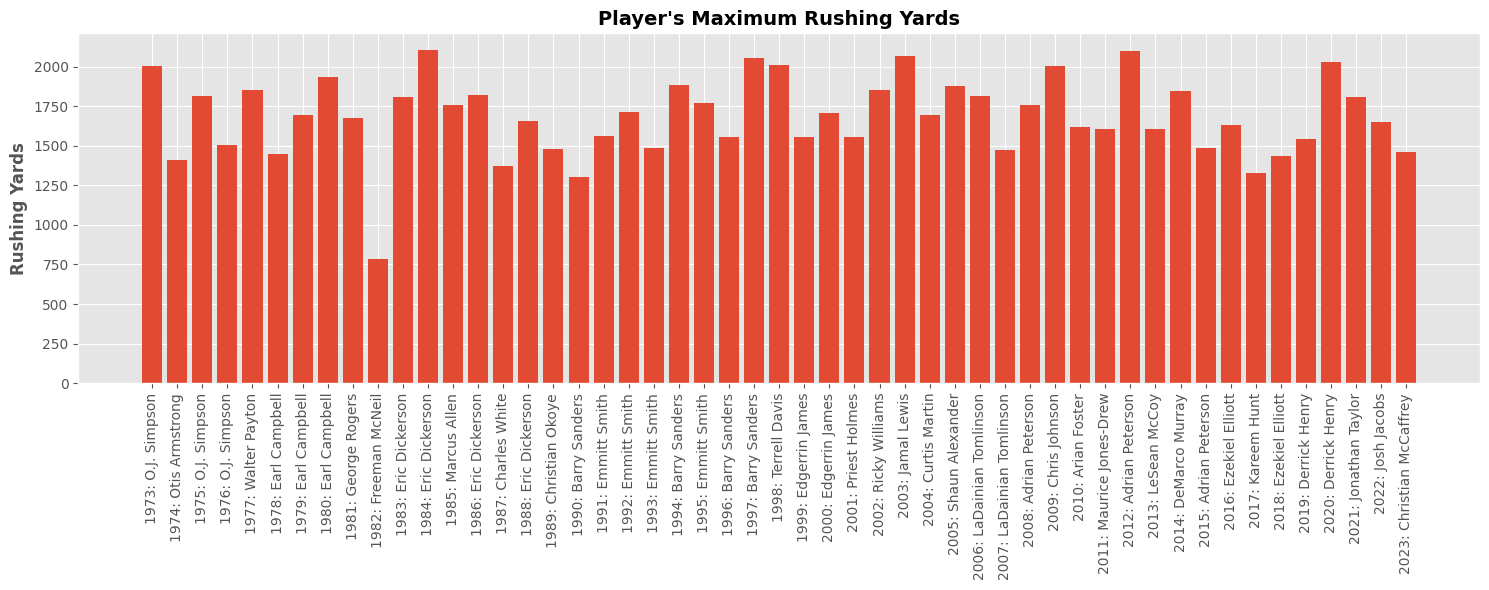

In [9]:
fig = plt.figure(figsize=(15,6)) 
ax = fig.add_subplot() 

ax.bar(x=stats_df.apply(lambda row: "%s: %s" % ( row['Year'], row['Player'] ) , axis=1).tolist(), height=stats_df['Rush Yds'].tolist() )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Player's Maximum Rushing Yards", fontweight='bold', fontsize=14)
ax.set_ylabel("Rushing Yards", fontweight='bold')
plt.tight_layout() 

## **Player Career Stats**

In [4]:
search_player_url: str = json.loads( secrets.get_secret_value(SecretId='nfl_stats').get('SecretString')).get('search_player')

In [34]:
search_player(search_player_url=search_player_url, player_name=stats_df['Player'].unique()[20] )

[{'player_name': 'Adrian Peterson',
  'url': 'PeteAd00',
  'data': '{"data_1": [{"Unnamed: 0_level_0 Year": "2002", "Unnamed: 1_level_0 Age": "23", "Unnamed: 2_level_0 Tm": "CHI", "Unnamed: 3_level_0 Pos": "RB", "Unnamed: 4_level_0 No.": 29.0, "Games G": 9, "Games GS": 0, "Rushing Att": 19, "Rushing Yds": 101, "Rushing TD": 1, "Rushing 1D": 4, "Rushing Succ%": 63.2, "Rushing Lng": 14, "Rushing Y/A": 5.3, "Rushing Y/G": 11.2, "Rushing A/G": 2.1, "Receiving Tgt": 4, "Receiving Rec": 3, "Receiving Yds": 18, "Receiving Y/R": 6.0, "Receiving TD": 0, "Receiving 1D": 1, "Receiving Succ%": 50.0, "Receiving Lng": 16, "Receiving R/G": 0.3, "Receiving Y/G": 2.0, "Receiving Ctch%": "75.0%", "Receiving Y/Tgt": 4.5, "Total Yds Touch": 22, "Total Yds Y/Tch": 5.4, "Total Yds YScm": 119, "Unnamed: 31_level_0 RRTD": 1, "Unnamed: 32_level_0 Fmb": 0, "Unnamed: 33_level_0 AV": 1}, {"Unnamed: 0_level_0 Year": "2003", "Unnamed: 1_level_0 Age": "24", "Unnamed: 2_level_0 Tm": "CHI", "Unnamed: 3_level_0 Pos": "